In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import math
from sklearn.decomposition import PCA

In [2]:
phase1_df_raw=pd.read_csv('phase1_raw_slope(5.18).csv',low_memory=False)
wt_df_raw1 = phase1_df_raw[phase1_df_raw['mutant_ID'] == 'WT']
mutant_df_raw1 = phase1_df_raw[phase1_df_raw['mutant_ID'] != 'WT']

In [3]:
phase2_df_raw=pd.read_csv('phase2_99_raw_slope(5.18)_newplate.csv',low_memory=False)
wt_df_raw2 = phase2_df_raw[phase2_df_raw['mutant_ID'] == 'WT']
mutant_df_raw2 = phase2_df_raw[phase2_df_raw['mutant_ID'] != 'WT']

In [10]:
# phase 1 quantile normalization
phase1_df1=pd.read_csv('phase1_qn_slopes(5.18).csv',low_memory=False)
wt_df1 = phase1_df1[phase1_df1['mutant_ID'] == 'WT']
mutant_df1 = phase1_df1[phase1_df1['mutant_ID'] != 'WT']

In [31]:
# phase 2 QN (across plates) row: well
phase2_df1=pd.read_csv('phase2_99_qn_across_slopes(5.18).csv',low_memory=False)
wt_df2 = phase2_df1[phase2_df1['mutant_ID'] == 'WT']
mutant_df2= phase2_df1[phase2_df1['mutant_ID'] != 'WT']

In [62]:
# phase 2 bayesian (across plates) +std
phase2_df2=pd.read_csv('phase2_99_bay_std_across_slope(5.18).csv',low_memory=False)
wt_df3 = phase2_df2[phase2_df2['mutant_ID'] == 'WT']
mutant_df3= phase2_df2[phase2_df2['mutant_ID'] != 'WT']

In [45]:
# phase 2 QN (within plates) row: well
phase2_df3=pd.read_csv('phase2_99_qn_within_slopes(5.18).csv',low_memory=False)
wt_df4 = phase2_df3[phase2_df3['mutant_ID'] == 'WT']
mutant_df4= phase2_df3[phase2_df3['mutant_ID'] != 'WT']

### compare debatched mutant slopes phase I and phase II (rank & value)

In [12]:
def plot_mutant_phase_comparison1(mutant_df1, mutant_df2, title_prefix,
                                   df1_slope_col='y2_slope', df2_slope_col='y2_slope',
                                   df1_slope_on_col='y2_slope_on', df2_slope_on_col='y2_slope_on'):
    """
    Compare Phase I (from mutant_df1) and Phase II (from mutant_df2) slopes using TLS across light regimes.

    """
    light_regimes = ['20h_ML', '20h_HL', '2h-2h', '10min-10min', '1min-1min', '30s-30s']
    alt_light_regimes = ['2h-2h', '10min-10min', '1min-1min', '30s-30s']
    
    n = len(light_regimes)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
    axes = axes.flatten()

    for i, regime in enumerate(light_regimes):
        # Choose the correct slope columns based on the regime
        if regime in alt_light_regimes:
            slope_col1 = df1_slope_on_col
            slope_col2 = df2_slope_on_col
        else:
            slope_col1 = df1_slope_col
            slope_col2 = df2_slope_col

        df1_sub = mutant_df1[mutant_df1['light_regime'] == regime]
        df2_sub = mutant_df2[mutant_df2['light_regime'] == regime]

        df1_grouped = df1_sub.groupby(['mutant_ID', 'mutated_genes'])[slope_col1].mean().reset_index()
        df1_grouped = df1_grouped.rename(columns={slope_col1: 'Phase I'})

        df2_grouped = df2_sub.groupby(['mutant_ID', 'mutated_genes'])[slope_col2].mean().reset_index()
        df2_grouped = df2_grouped.rename(columns={slope_col2: 'Phase II'})

        merged = pd.merge(df1_grouped, df2_grouped, on=['mutant_ID', 'mutated_genes'])
        if merged.empty:
            continue

        x = merged['Phase I'].values
        y = merged['Phase II'].values

        # Filter invalid values
        valid_mask = np.isfinite(x) & np.isfinite(y)
        x = x[valid_mask]
        y = y[valid_mask]
        X = np.stack([x, y], axis=1)

        # TLS (PCA)
        pca = PCA(n_components=1)
        X_pca = pca.fit_transform(X)
        X_tls = pca.inverse_transform(X_pca)

        # Plotting
        ax = axes[i]
        ax.scatter(x, y, s=5, label='Mutants')
        ax.plot(X_tls[:, 0], X_tls[:, 1], color='orange', linewidth=2, label='TLS (PCA)')
        ax.plot([x.min(), x.max()], [x.min(), x.max()], 'k--', label='y = x')

        corr1, _ = pearsonr(x, y)
        corr2, _ = spearmanr(x, y)
        ax.set_xlabel('Phase I slope')
        ax.set_ylabel('Phase II slope')
        ax.set_title(f'{title_prefix} ({regime})\nPearson r1 = {corr1:.2f}, Spearman r2 = {corr2:.2f}')
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

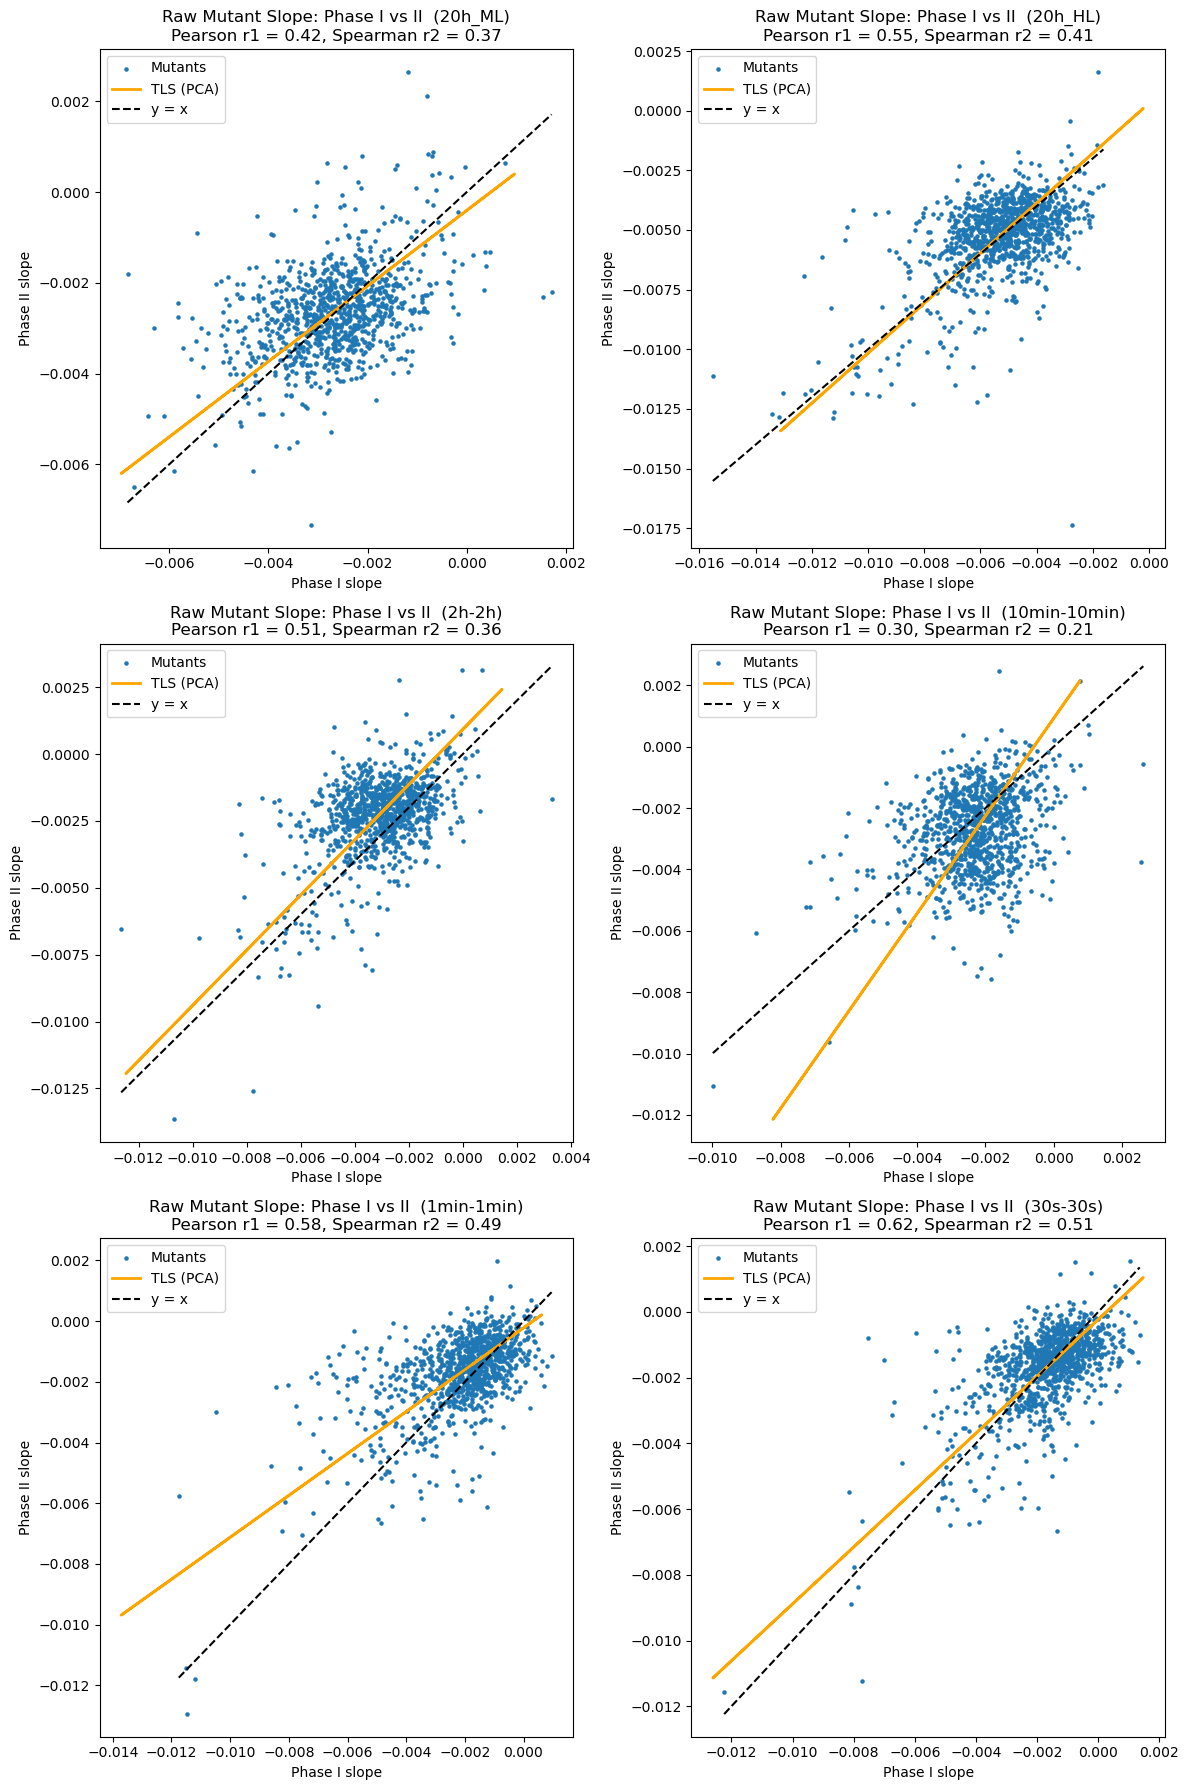

In [13]:
plot_mutant_phase_comparison1(mutant_df_raw1, mutant_df_raw2, 
                              'Raw Mutant Slope: Phase I vs II ')

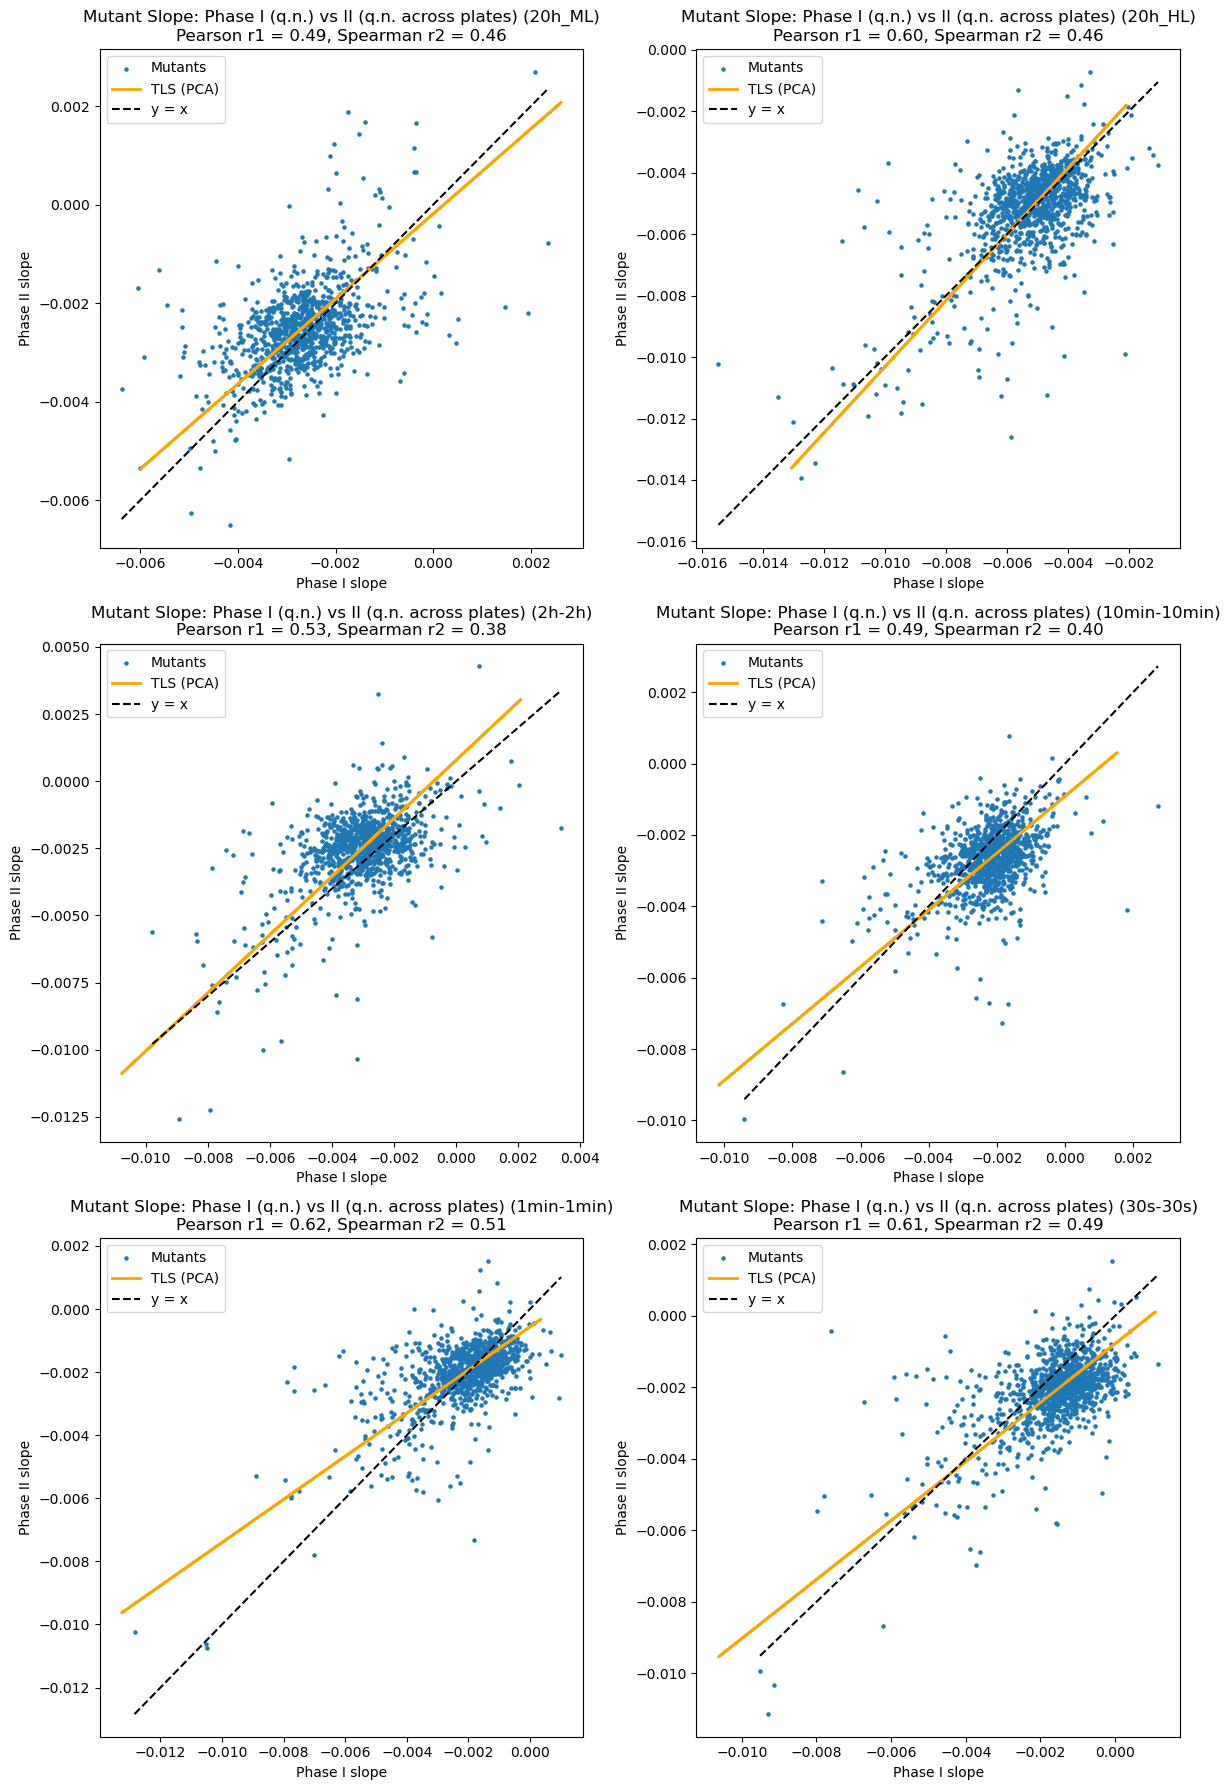

In [33]:
plot_mutant_phase_comparison1(mutant_df1, mutant_df2, 'Mutant Slope: Phase I (q.n.) vs II (q.n. across plates)')

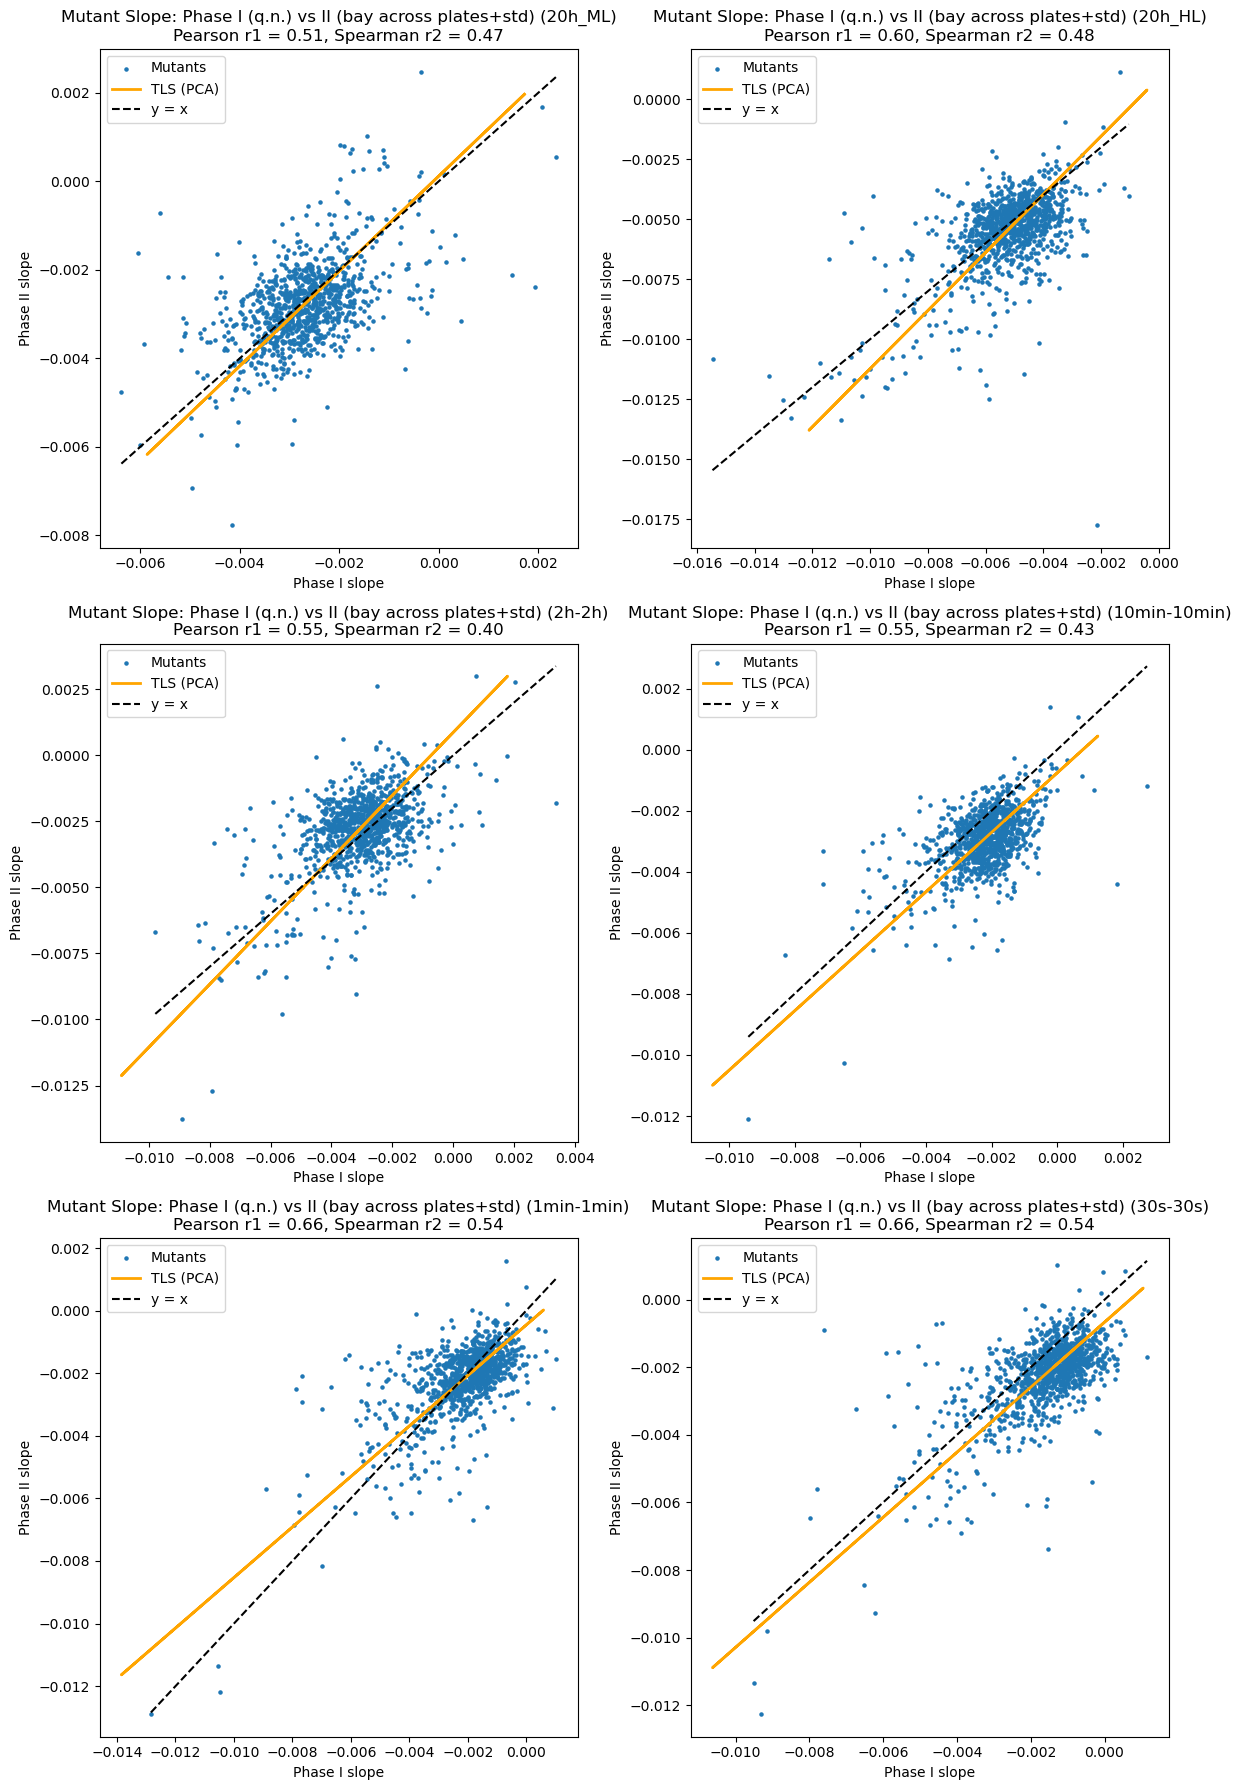

In [56]:
plot_mutant_phase_comparison1(mutant_df1, mutant_df3, 'Mutant Slope: Phase I (q.n.) vs II (bay across plates+std)')

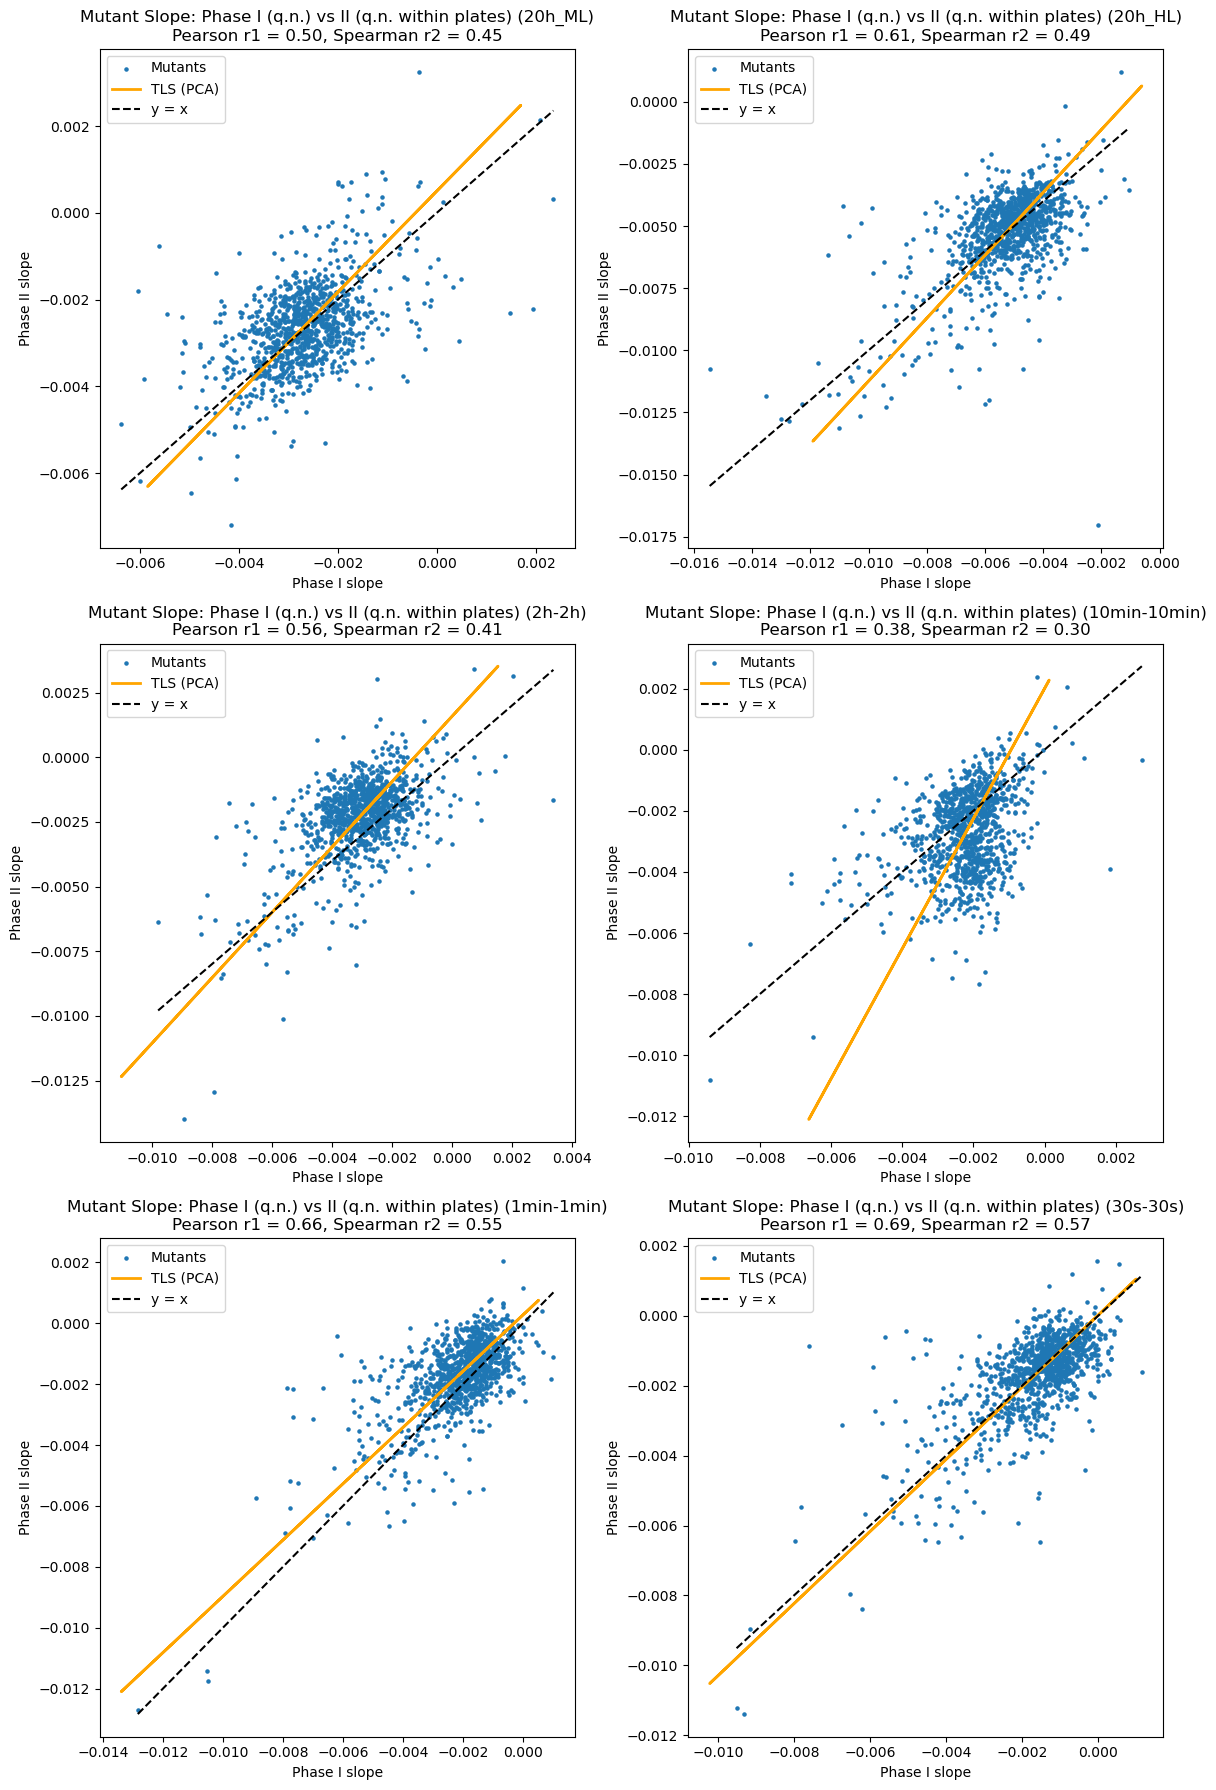

In [48]:
plot_mutant_phase_comparison1(mutant_df1, mutant_df4, 'Mutant Slope: Phase I (q.n.) vs II (q.n. within plates)')

## compare replicas in phase 2


In [16]:
def plot_pairwise_replicates_with_tls_within_plate(
    mutant_df, 
    slope_col_main='y2_slope', 
    slope_col_on='y2_slope_on', 
    title_prefix=''
):
    light_regimes = ['20h_ML','20h_HL','5min-5min', '1min-5min','2h-2h', '10min-10min', '1min-1min','30s-30s']
    ncols = 2
    nrows = math.ceil(len(light_regimes) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
    axes = axes.flatten()

    for i, regime in enumerate(light_regimes):
        sub_df = mutant_df[mutant_df['light_regime'] == regime].copy()

        slope_col = slope_col_main if regime in ['20h_ML', '20h_HL'] else slope_col_on
        sub_df = sub_df[['mutant_ID', 'mutated_genes', 'plate', 'light_regime', slope_col]].copy()
        sub_df = sub_df.rename(columns={slope_col: 'slope'})

        # Extract plate base (e.g., 30 from '30v1_1' or '30v2')
        sub_df['plate_base'] = sub_df['plate'].str.extract(r'^(30|31|32|33)')

        # Drop rows without matching plate_base
        sub_df = sub_df.dropna(subset=['plate_base'])

        # Count replicates by mutant and plate base
        counts = sub_df.groupby(['mutant_ID', 'mutated_genes', 'plate_base']).size().reset_index(name='n')
        valid_ids = counts[counts['n'] >= 2][['mutant_ID', 'mutated_genes', 'plate_base']]

        merged = pd.merge(sub_df, valid_ids, on=['mutant_ID', 'mutated_genes', 'plate_base'])

        # Select 2 replicates per mutant per plate base
        pairwise_rows = []
        for _, group in merged.groupby(['mutant_ID', 'mutated_genes', 'plate_base']):
            if len(group) >= 2:
                selected = group.sample(n=2, random_state=42)
                pairwise_rows.append(selected)

        if not pairwise_rows:
            continue

        pairwise_df = pd.concat(pairwise_rows).reset_index(drop=True)

        # Assign replicate index
        pairwise_df['rep_index'] = pairwise_df.groupby(['mutant_ID', 'mutated_genes', 'plate_base']).cumcount()
        df_wide = pairwise_df.pivot(index=['mutant_ID', 'mutated_genes', 'plate_base'], columns='rep_index', values='slope')
        df_wide = df_wide.dropna()

        if df_wide.shape[0] == 0:
            continue

        x = df_wide[0].values
        y = df_wide[1].values
        corr1, _ = pearsonr(x, y)
        corr2, _ = spearmanr(x, y)

        # TLS fit using PCA
        points = np.column_stack([x, y])
        pca = PCA(n_components=1)
        pca.fit(points)
        tls_fit = pca.inverse_transform(pca.transform(points))
        # Plot
        ax = axes[i]
        ax.scatter(x, y, s=5)
        ax.plot([x.min(), x.max()], [x.min(), x.max()], 'k--', label='y = x')
        ax.plot(tls_fit[:, 0], tls_fit[:, 1], color='orange', linewidth=2, label='TLS (PCA)')
        ax.set_xlabel('Replica 1')
        ax.set_ylabel('Replica 2')
        ax.set_title(f'{title_prefix}{regime}\nPearson r1 = {corr1:.2f}, Spearman r2 = {corr2:.2f}')
        ax.legend()

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


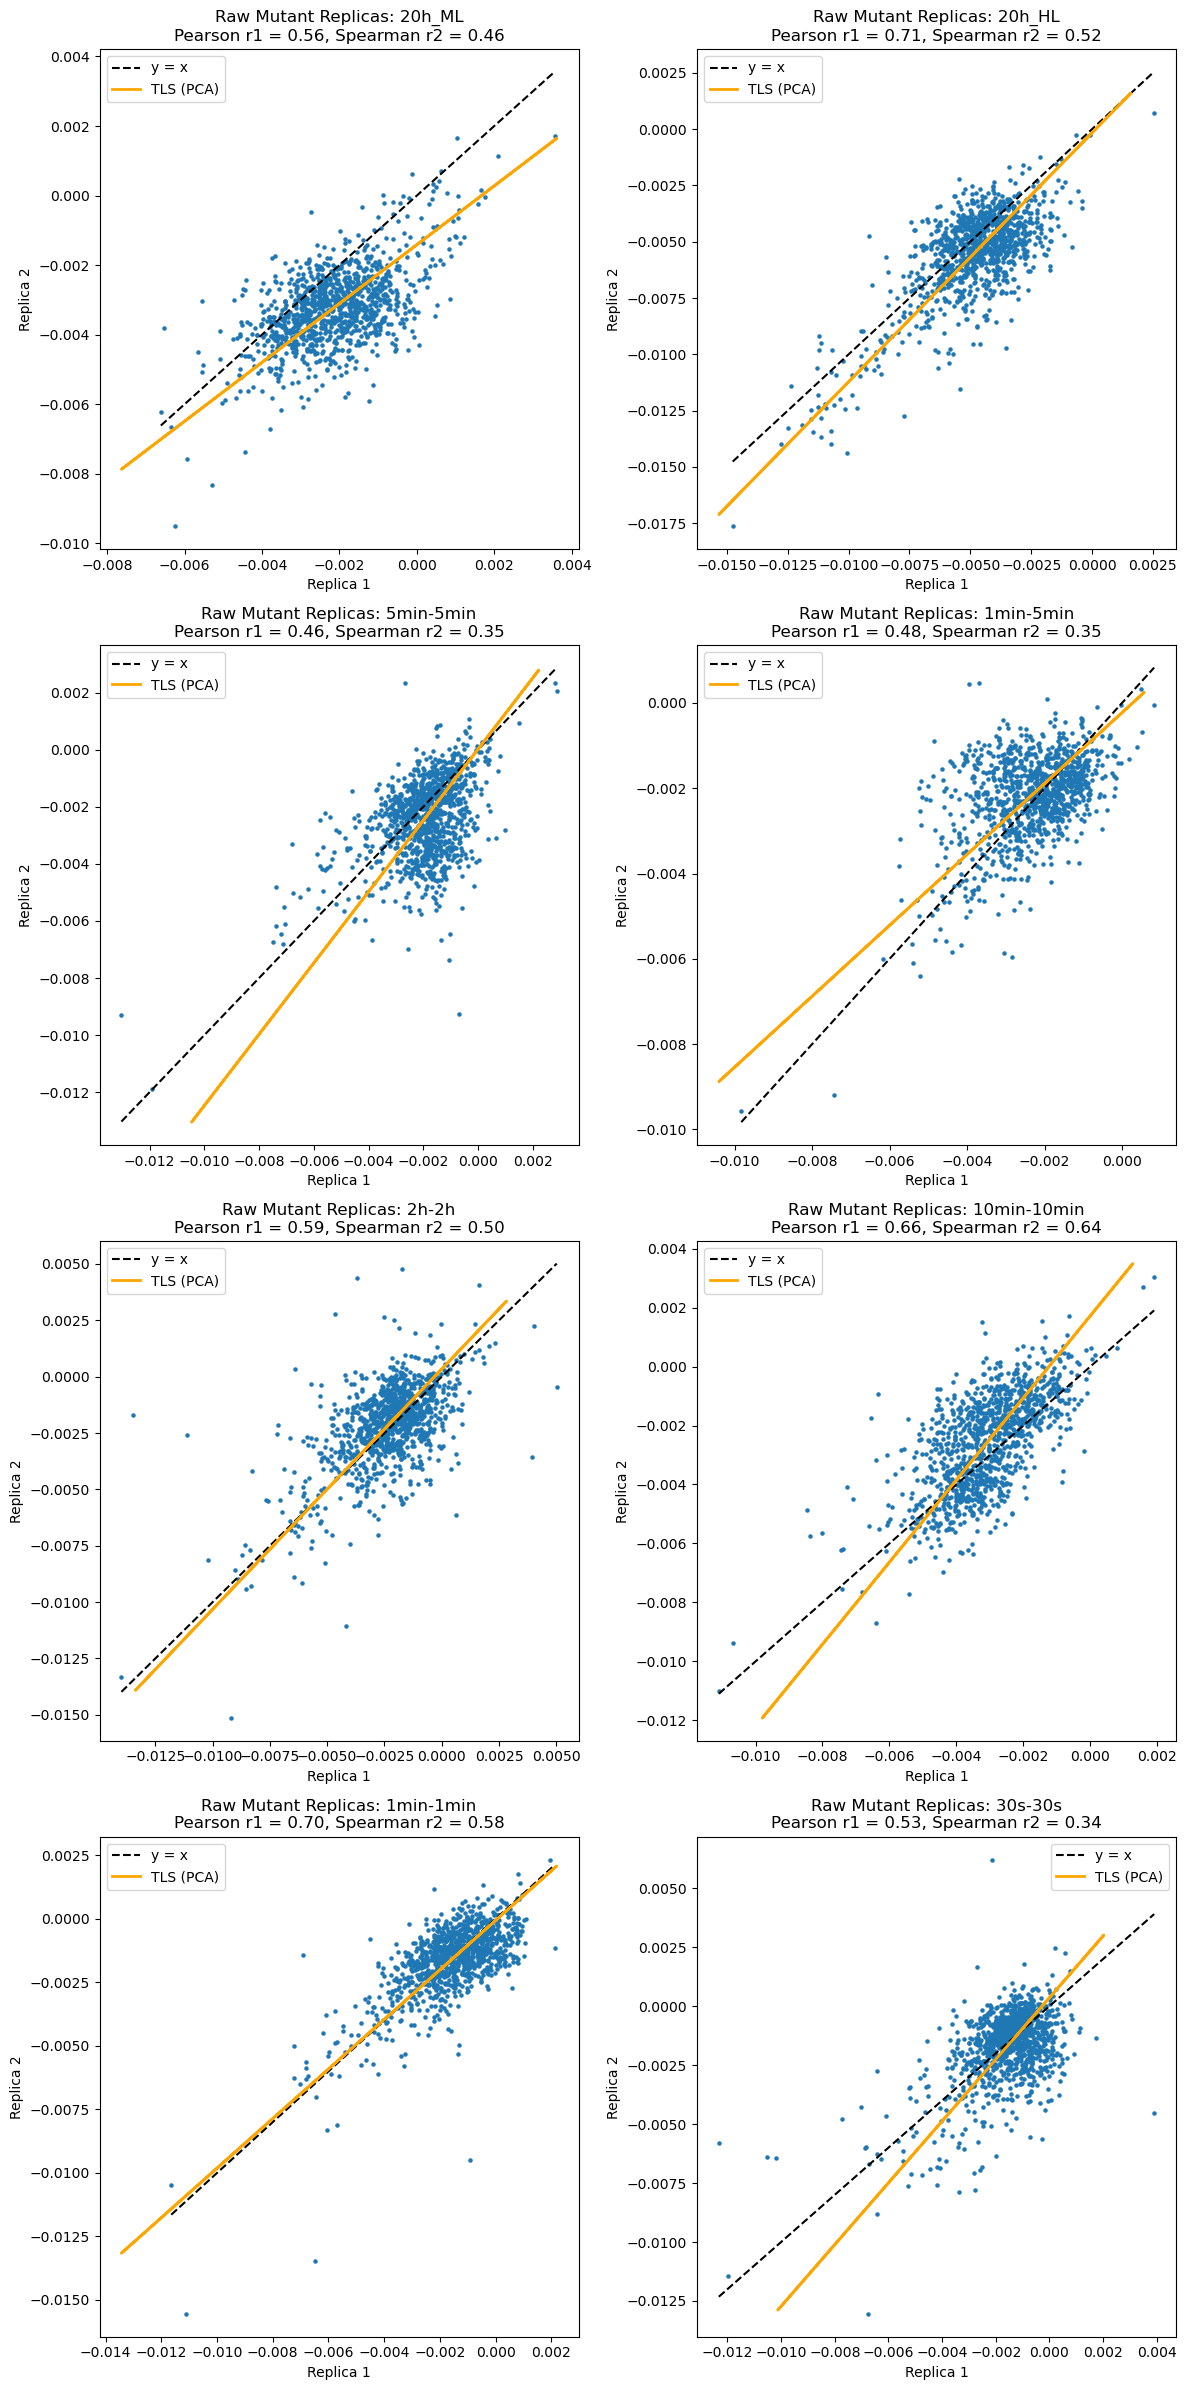

In [17]:
plot_pairwise_replicates_with_tls_within_plate(mutant_df_raw2, title_prefix='Raw Mutant Replicas: ')

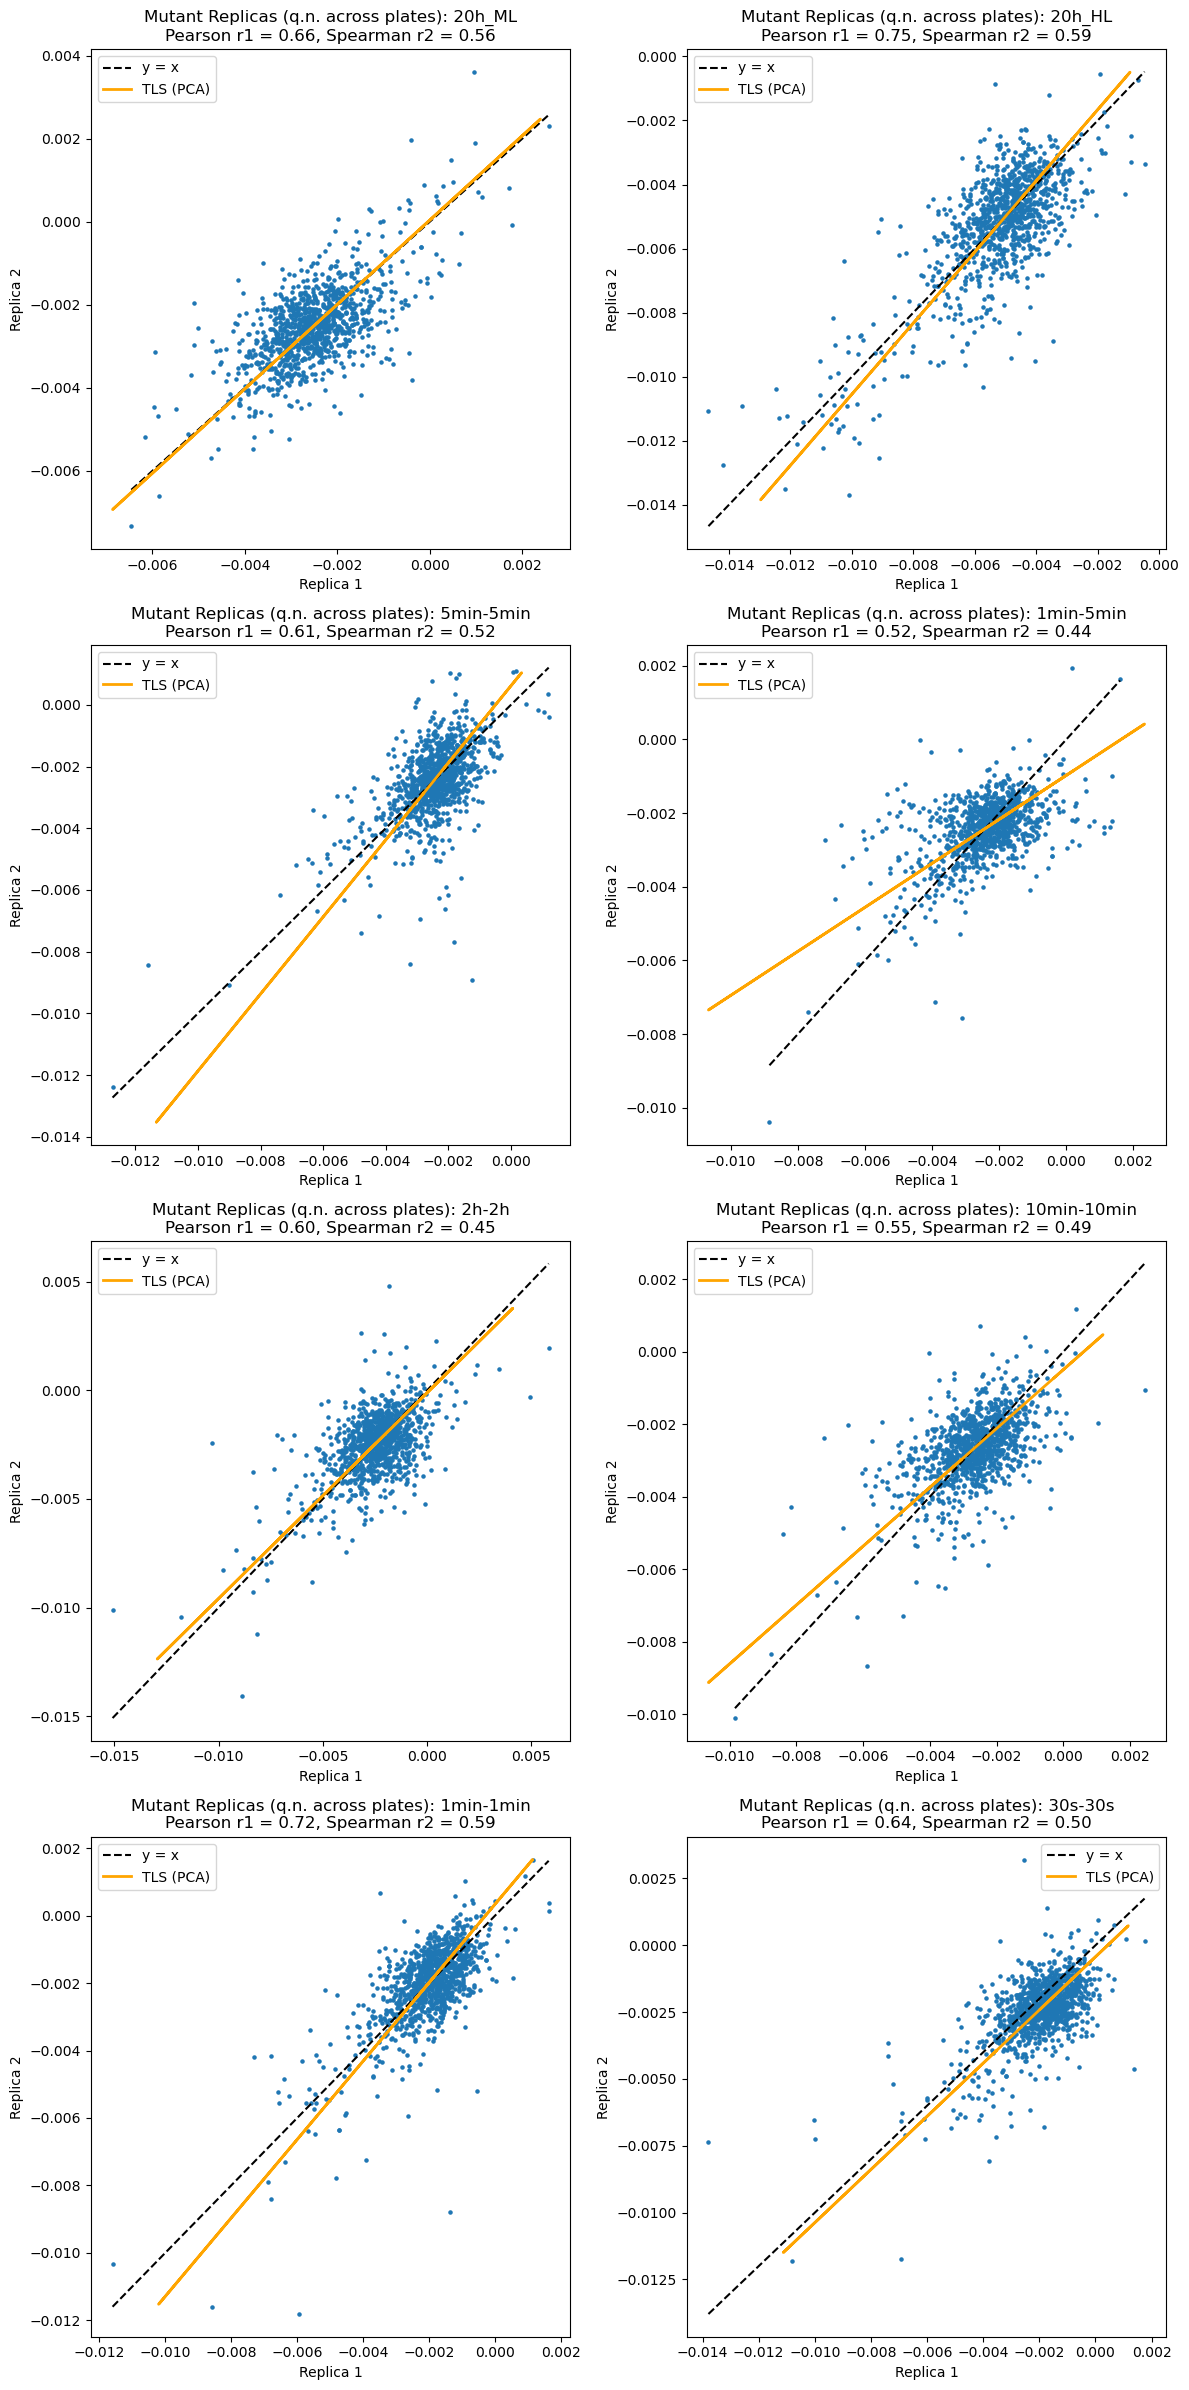

In [35]:
plot_pairwise_replicates_with_tls_within_plate(mutant_df2, title_prefix='Mutant Replicas (q.n. across plates): ')

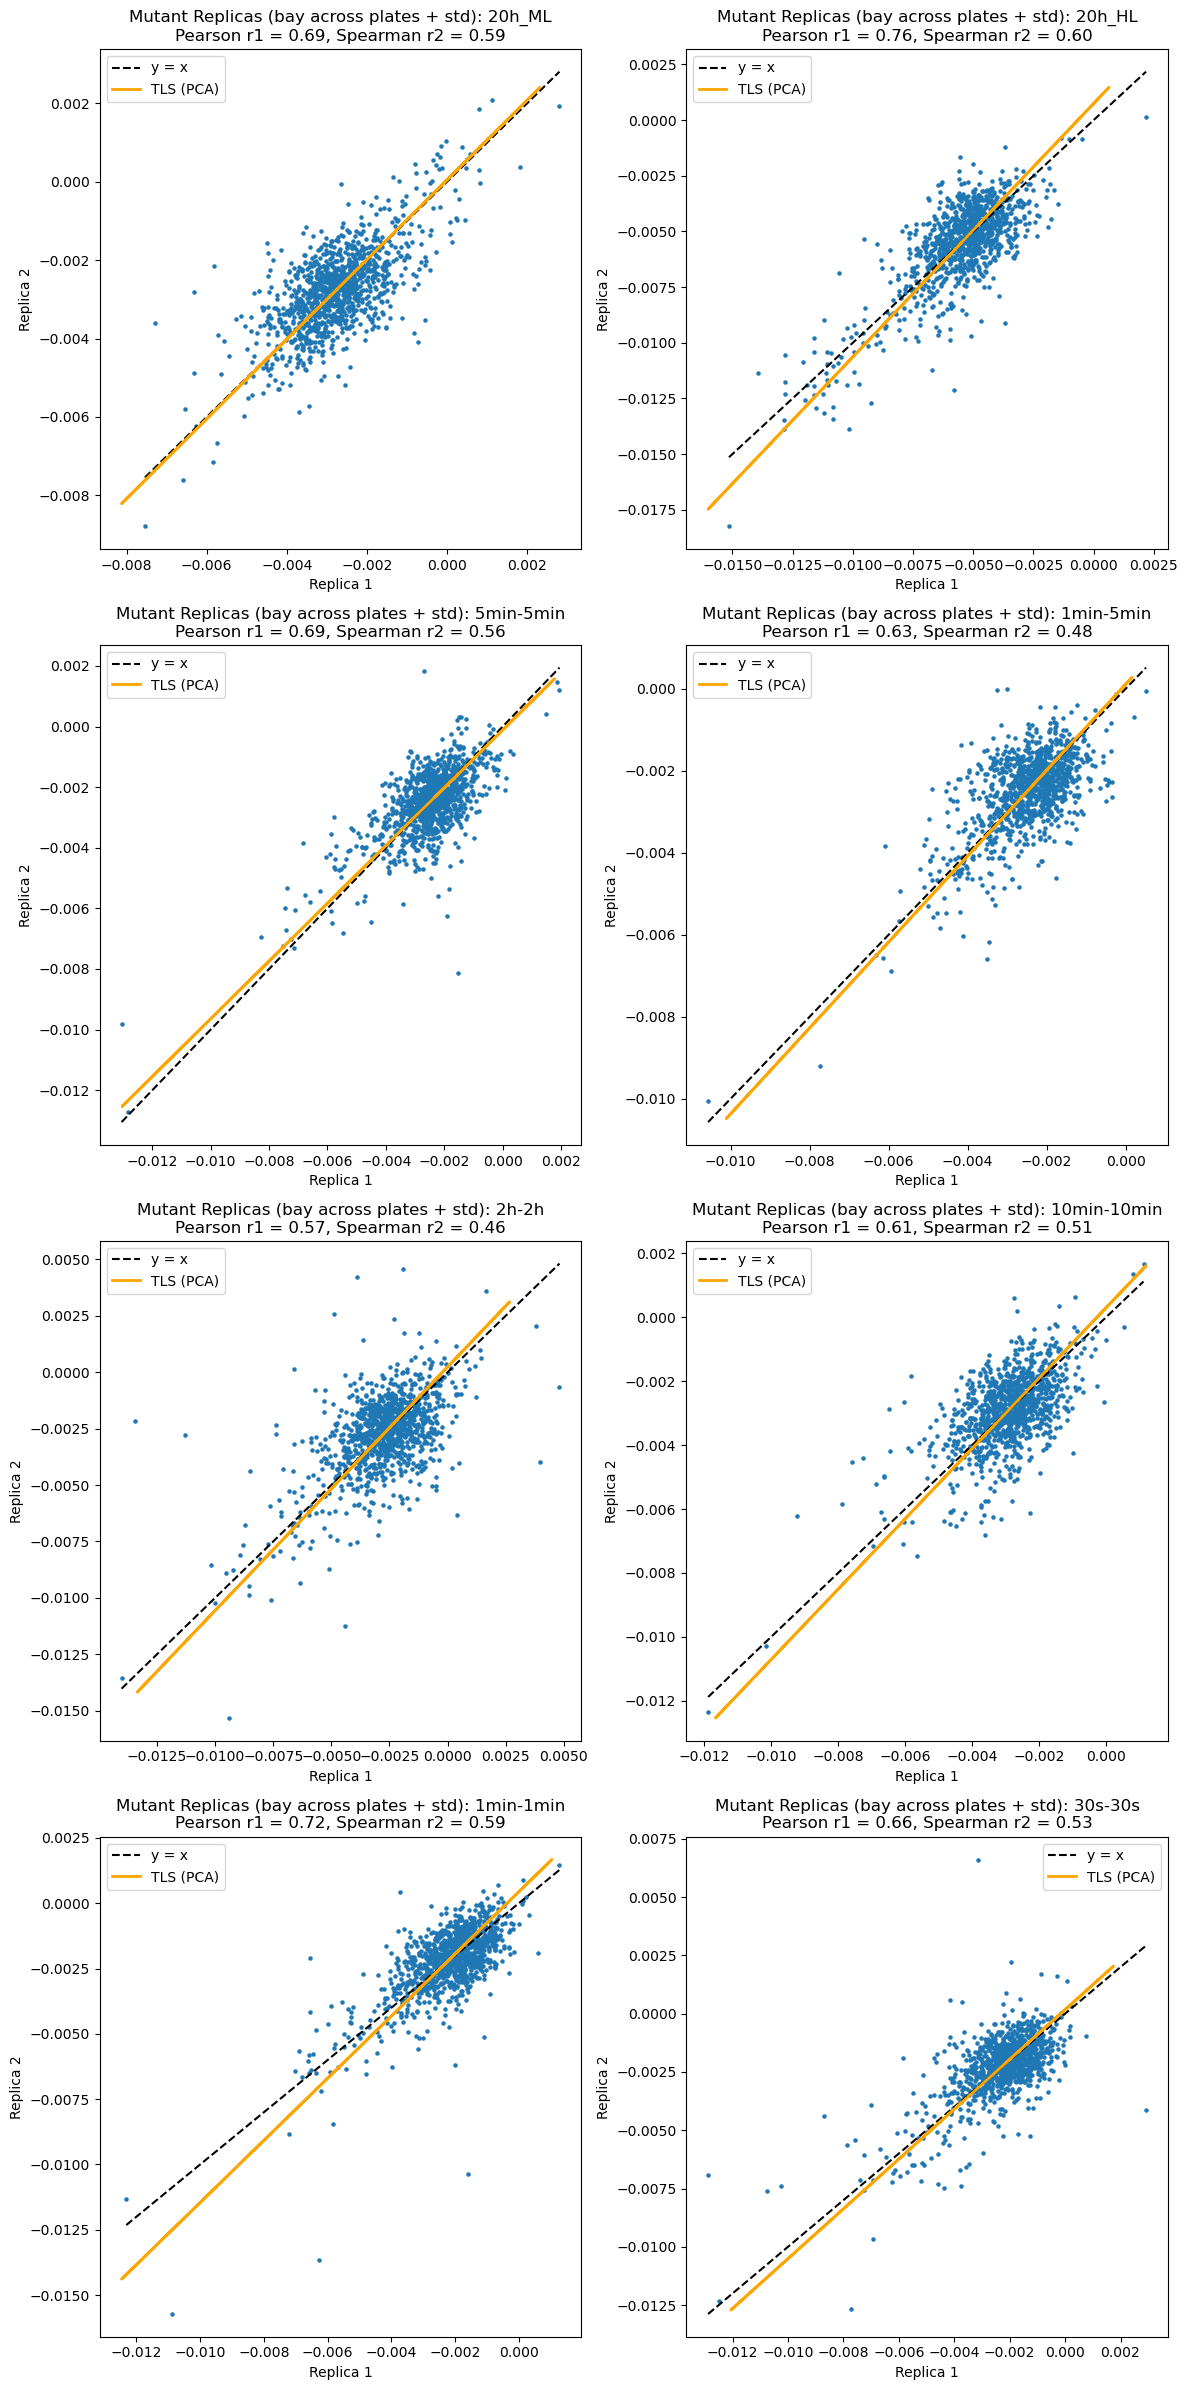

In [64]:
plot_pairwise_replicates_with_tls_within_plate(mutant_df3, title_prefix='Mutant Replicas (bay across plates + std): ')

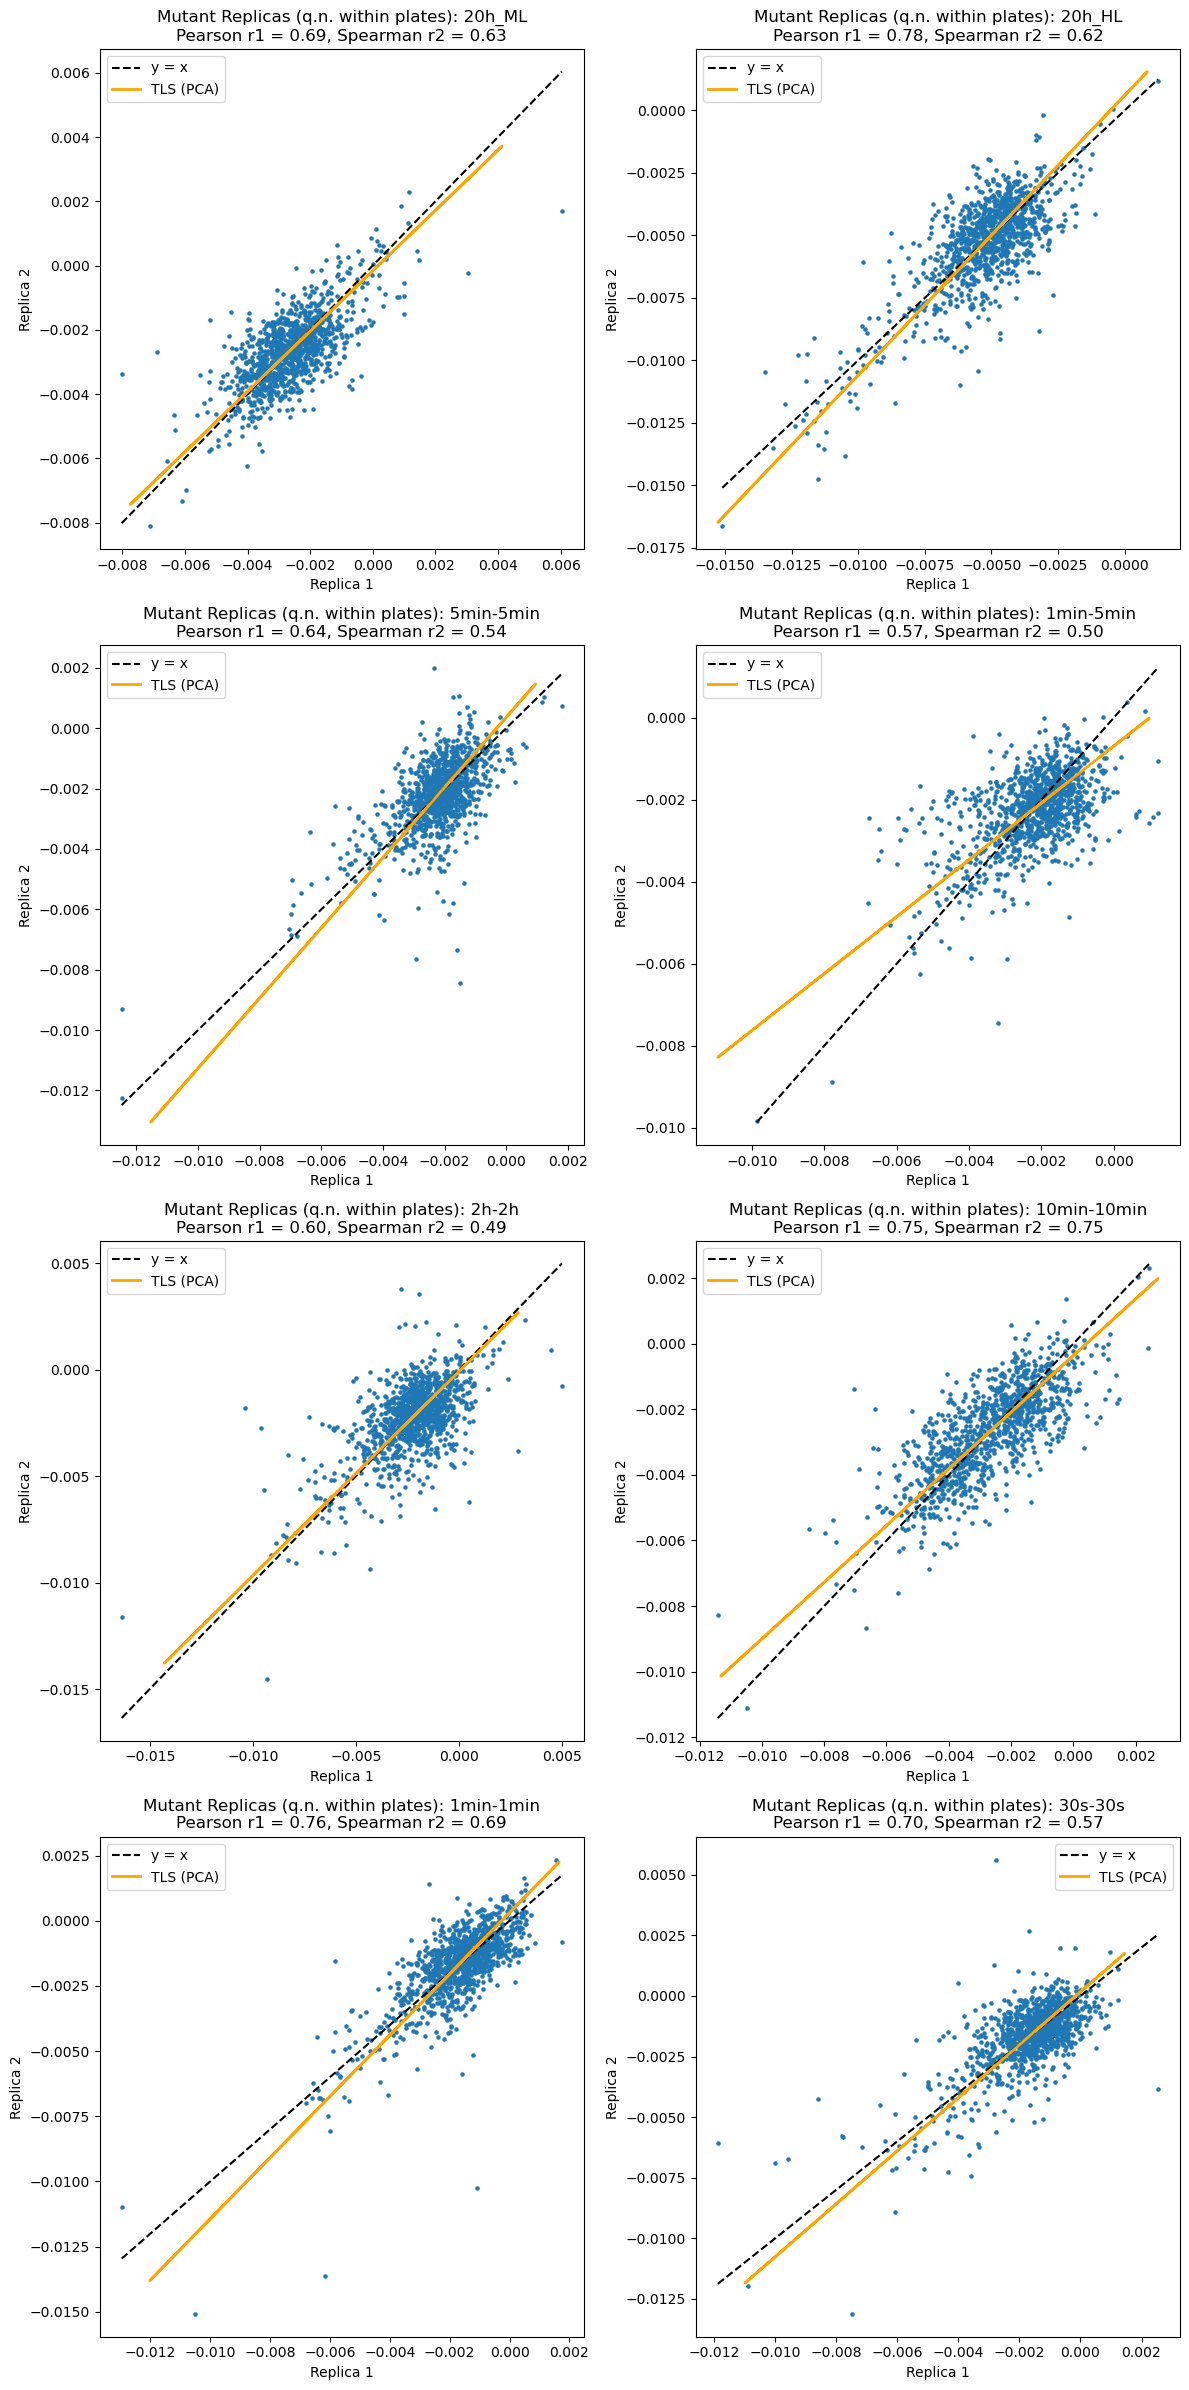

In [49]:
plot_pairwise_replicates_with_tls_within_plate(mutant_df4, title_prefix='Mutant Replicas (q.n. within plates): ')

## WT

In [20]:
def plot_pairwise_wildtype_tls(
    wt_df,
    slope_col_main='y2_slope',
    slope_col_on='y2_slope_on',
    title_prefix=''
):
    light_regimes = ['20h_ML','20h_HL','5min-5min', '1min-5min','2h-2h', '10min-10min', '1min-1min','30s-30s']
    ncols = 2
    nrows = math.ceil(len(light_regimes) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
    axes = axes.flatten()

    # Extract base plate (e.g., '30' from '30v1', '30v1_1')
    wt_df = wt_df.copy()
    wt_df['base_plate'] = wt_df['plate'].astype(str).str.extract(r'^(\d+)')[0]

    for i, regime in enumerate(light_regimes):
        sub_df = wt_df[wt_df['light_regime'] == regime].copy()

        # Choose slope column depending on regime
        slope_col = slope_col_main if regime in ['20h_ML', '20h_HL'] else slope_col_on

        if slope_col not in sub_df.columns:
            continue

        # Drop missing slopes
        sub_df = sub_df.dropna(subset=[slope_col])

        # Group by: base_plate, well_id — collect all wildtype replicates across subplates
        grouped = sub_df.groupby(['base_plate', 'well_id'])

        pairwise_rows = []

        for (base_plate, well_id), group in grouped:
            if len(group) >= 2:
                selected = group.sample(n=2, random_state=42)
                selected = selected.assign(base_plate=base_plate, well_id=well_id)
                pairwise_rows.append(selected)

        if not pairwise_rows:
            continue

        pairwise_df = pd.concat(pairwise_rows).reset_index(drop=True)
        pairwise_df['rep_index'] = pairwise_df.groupby(['base_plate', 'well_id']).cumcount()
        df_wide = pairwise_df.pivot(index=['base_plate', 'well_id'], columns='rep_index', values=slope_col)
        # print(df_wide)
        df_wide = df_wide.dropna()

        if df_wide.shape[0] == 0:
            continue

        x = df_wide[0].values
        y = df_wide[1].values
        corr1, _ = pearsonr(x, y)
        corr2, _ = spearmanr(x, y)

        # TLS (PCA)
        points = np.column_stack([x, y])
        pca = PCA(n_components=1)
        pca.fit(points)
        tls_fit = pca.inverse_transform(pca.transform(points))

        # Plot
        ax = axes[i]
        ax.scatter(x, y, s=5)
        ax.plot([x.min(), x.max()], [x.min(), x.max()], 'k--', label='y = x')
        ax.plot(tls_fit[:, 0], tls_fit[:, 1], color='orange', linewidth=2, label='TLS (PCA)')
        ax.set_xlabel('Replica 1')
        ax.set_ylabel('Replica 2')
        ax.set_title(f'{title_prefix}{regime}\nPearson r = {corr1:.2f}, Spearman r = {corr2:.2f}')
        ax.legend()

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

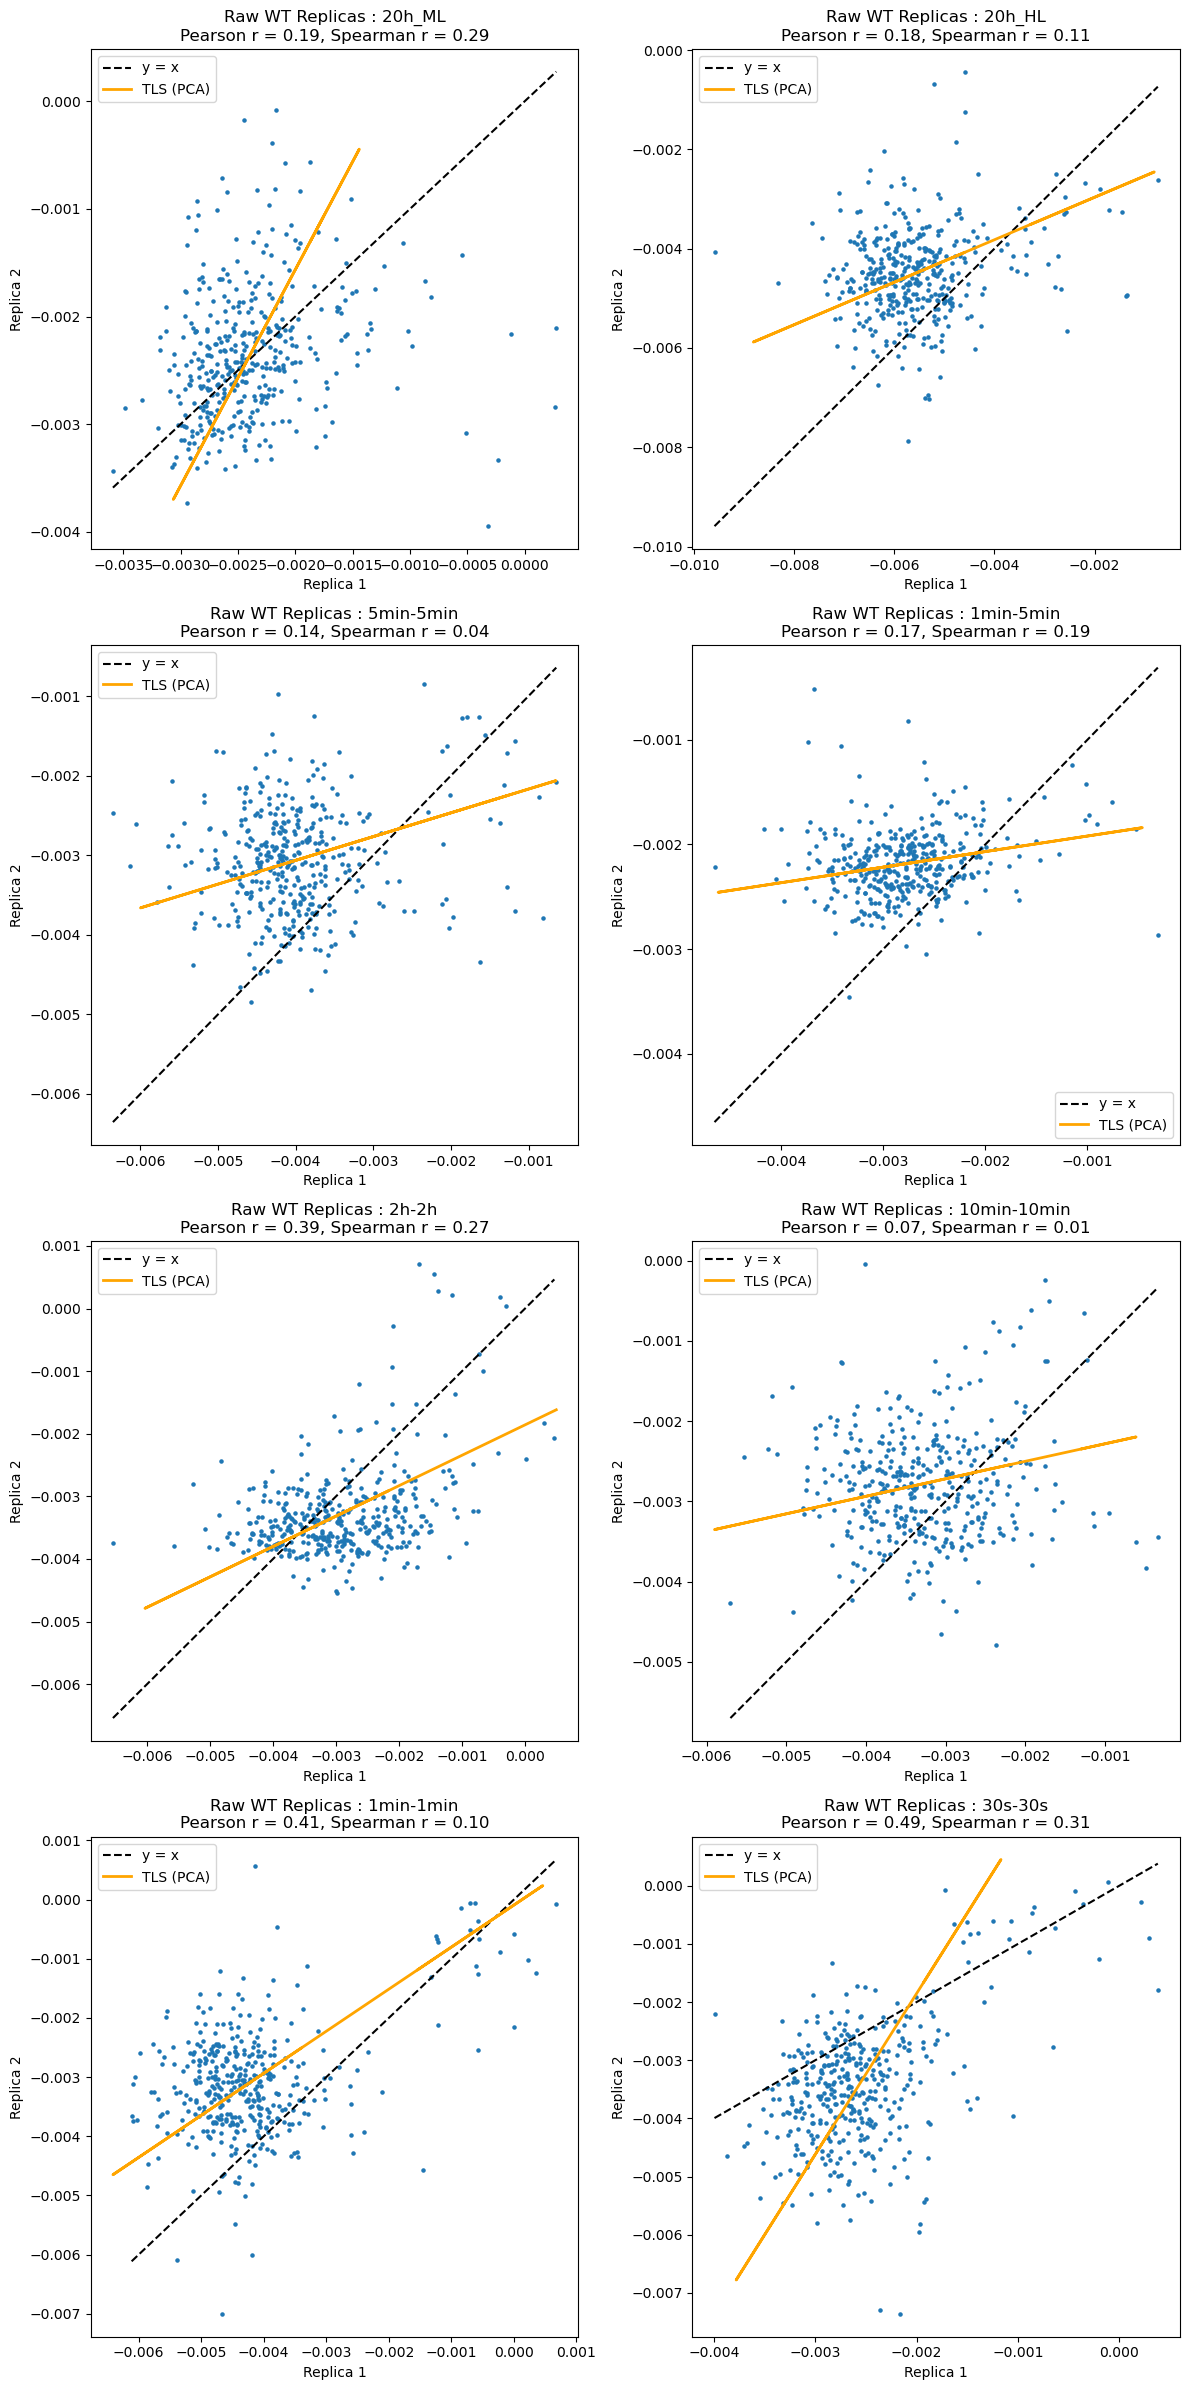

In [21]:
plot_pairwise_wildtype_tls(wt_df_raw2, title_prefix='Raw WT Replicas : ')

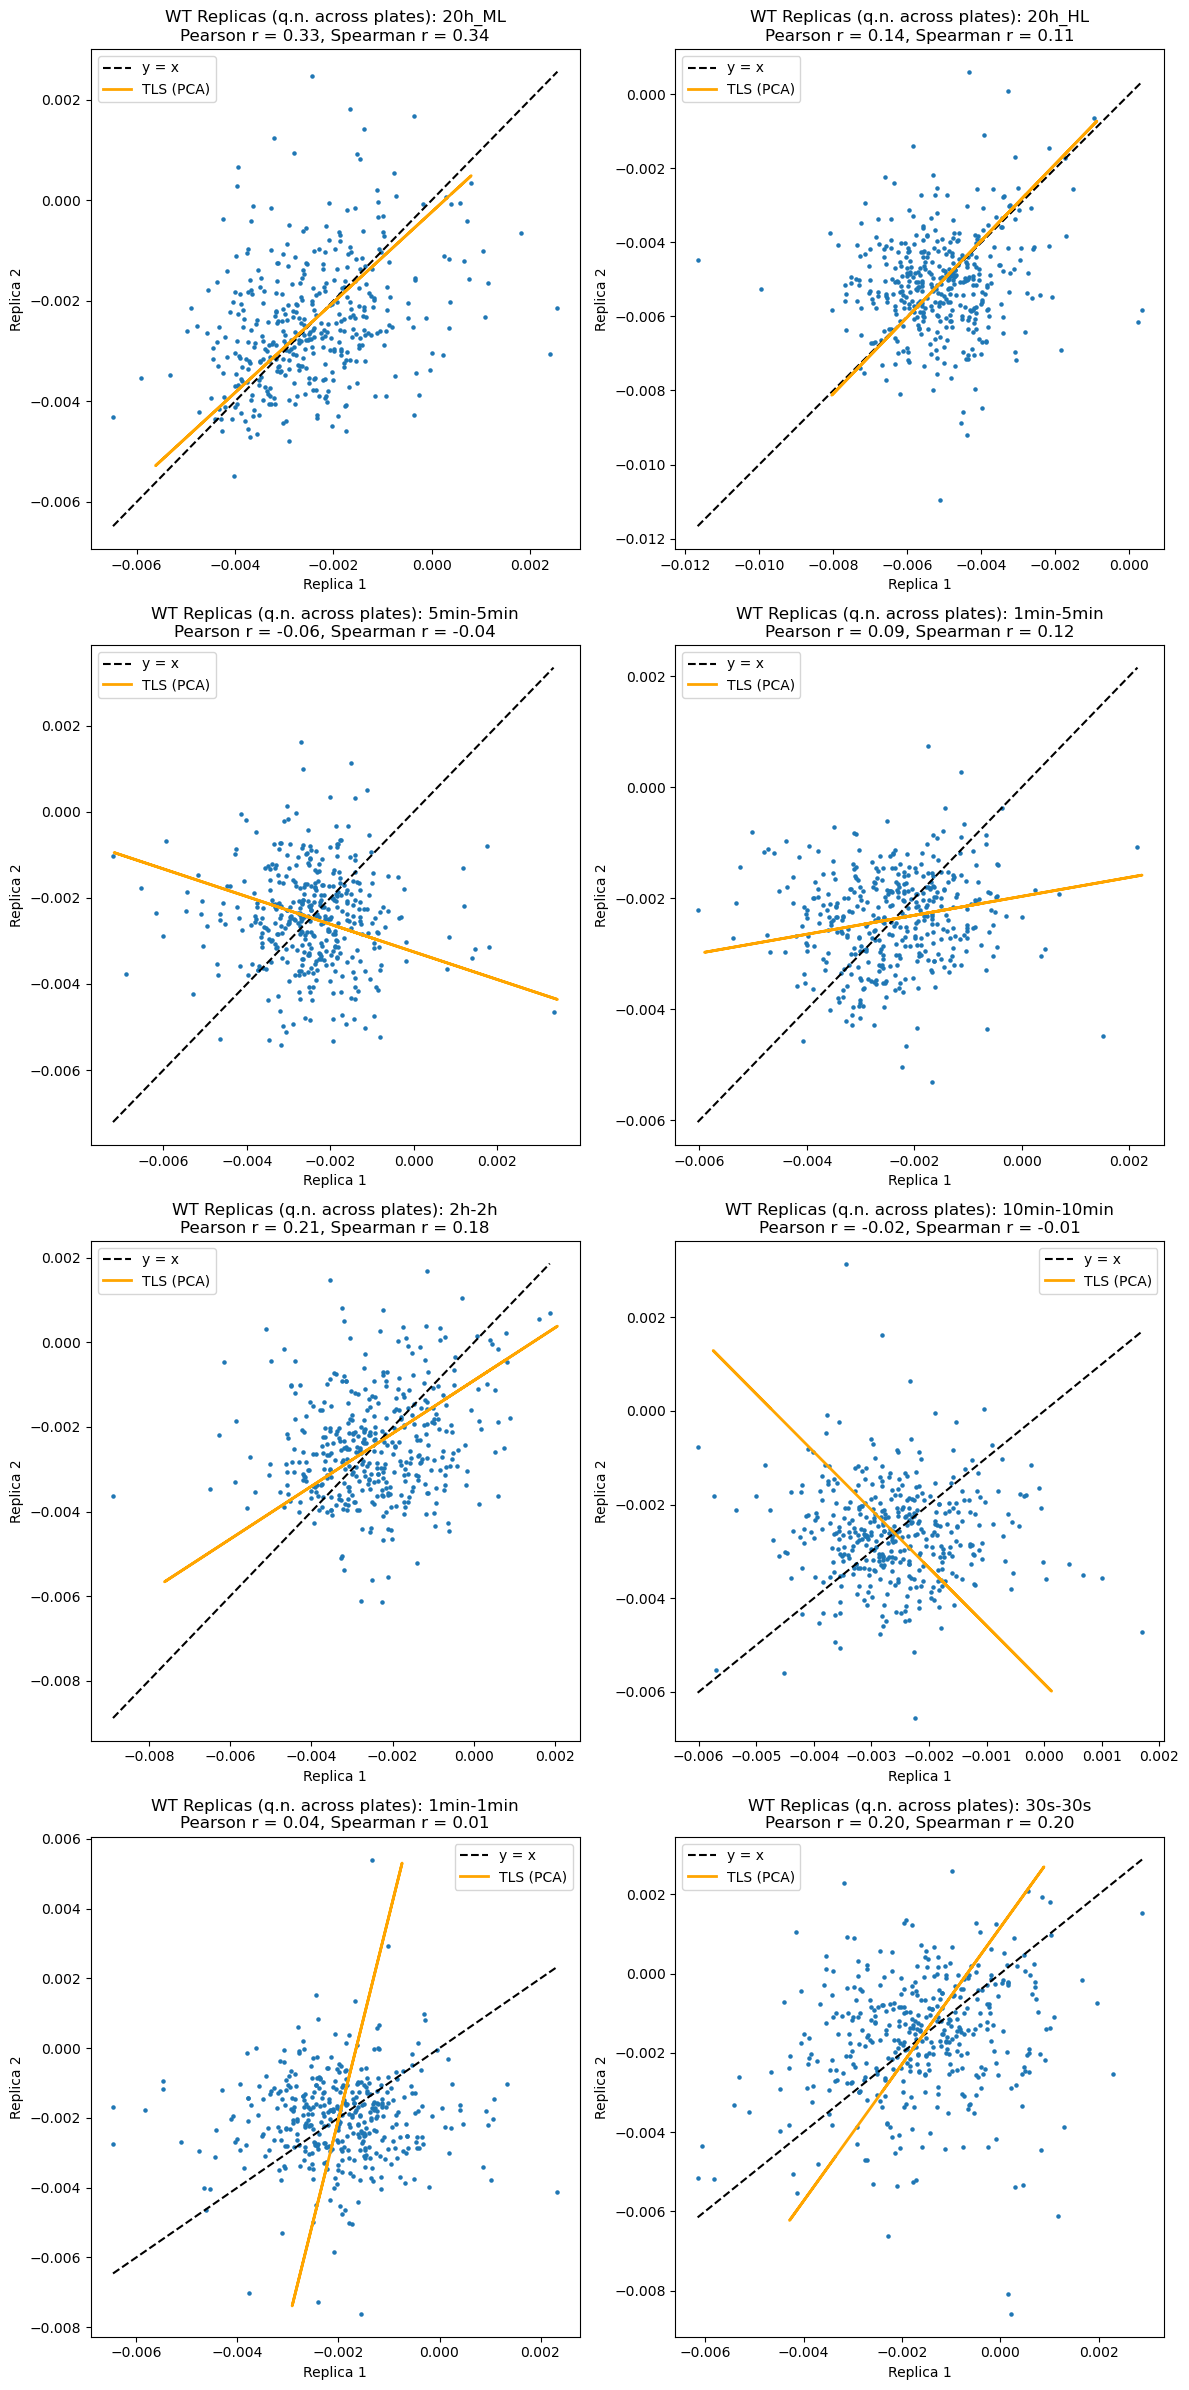

In [23]:
plot_pairwise_wildtype_tls(wt_df2, title_prefix='WT Replicas (q.n. across plates): ')

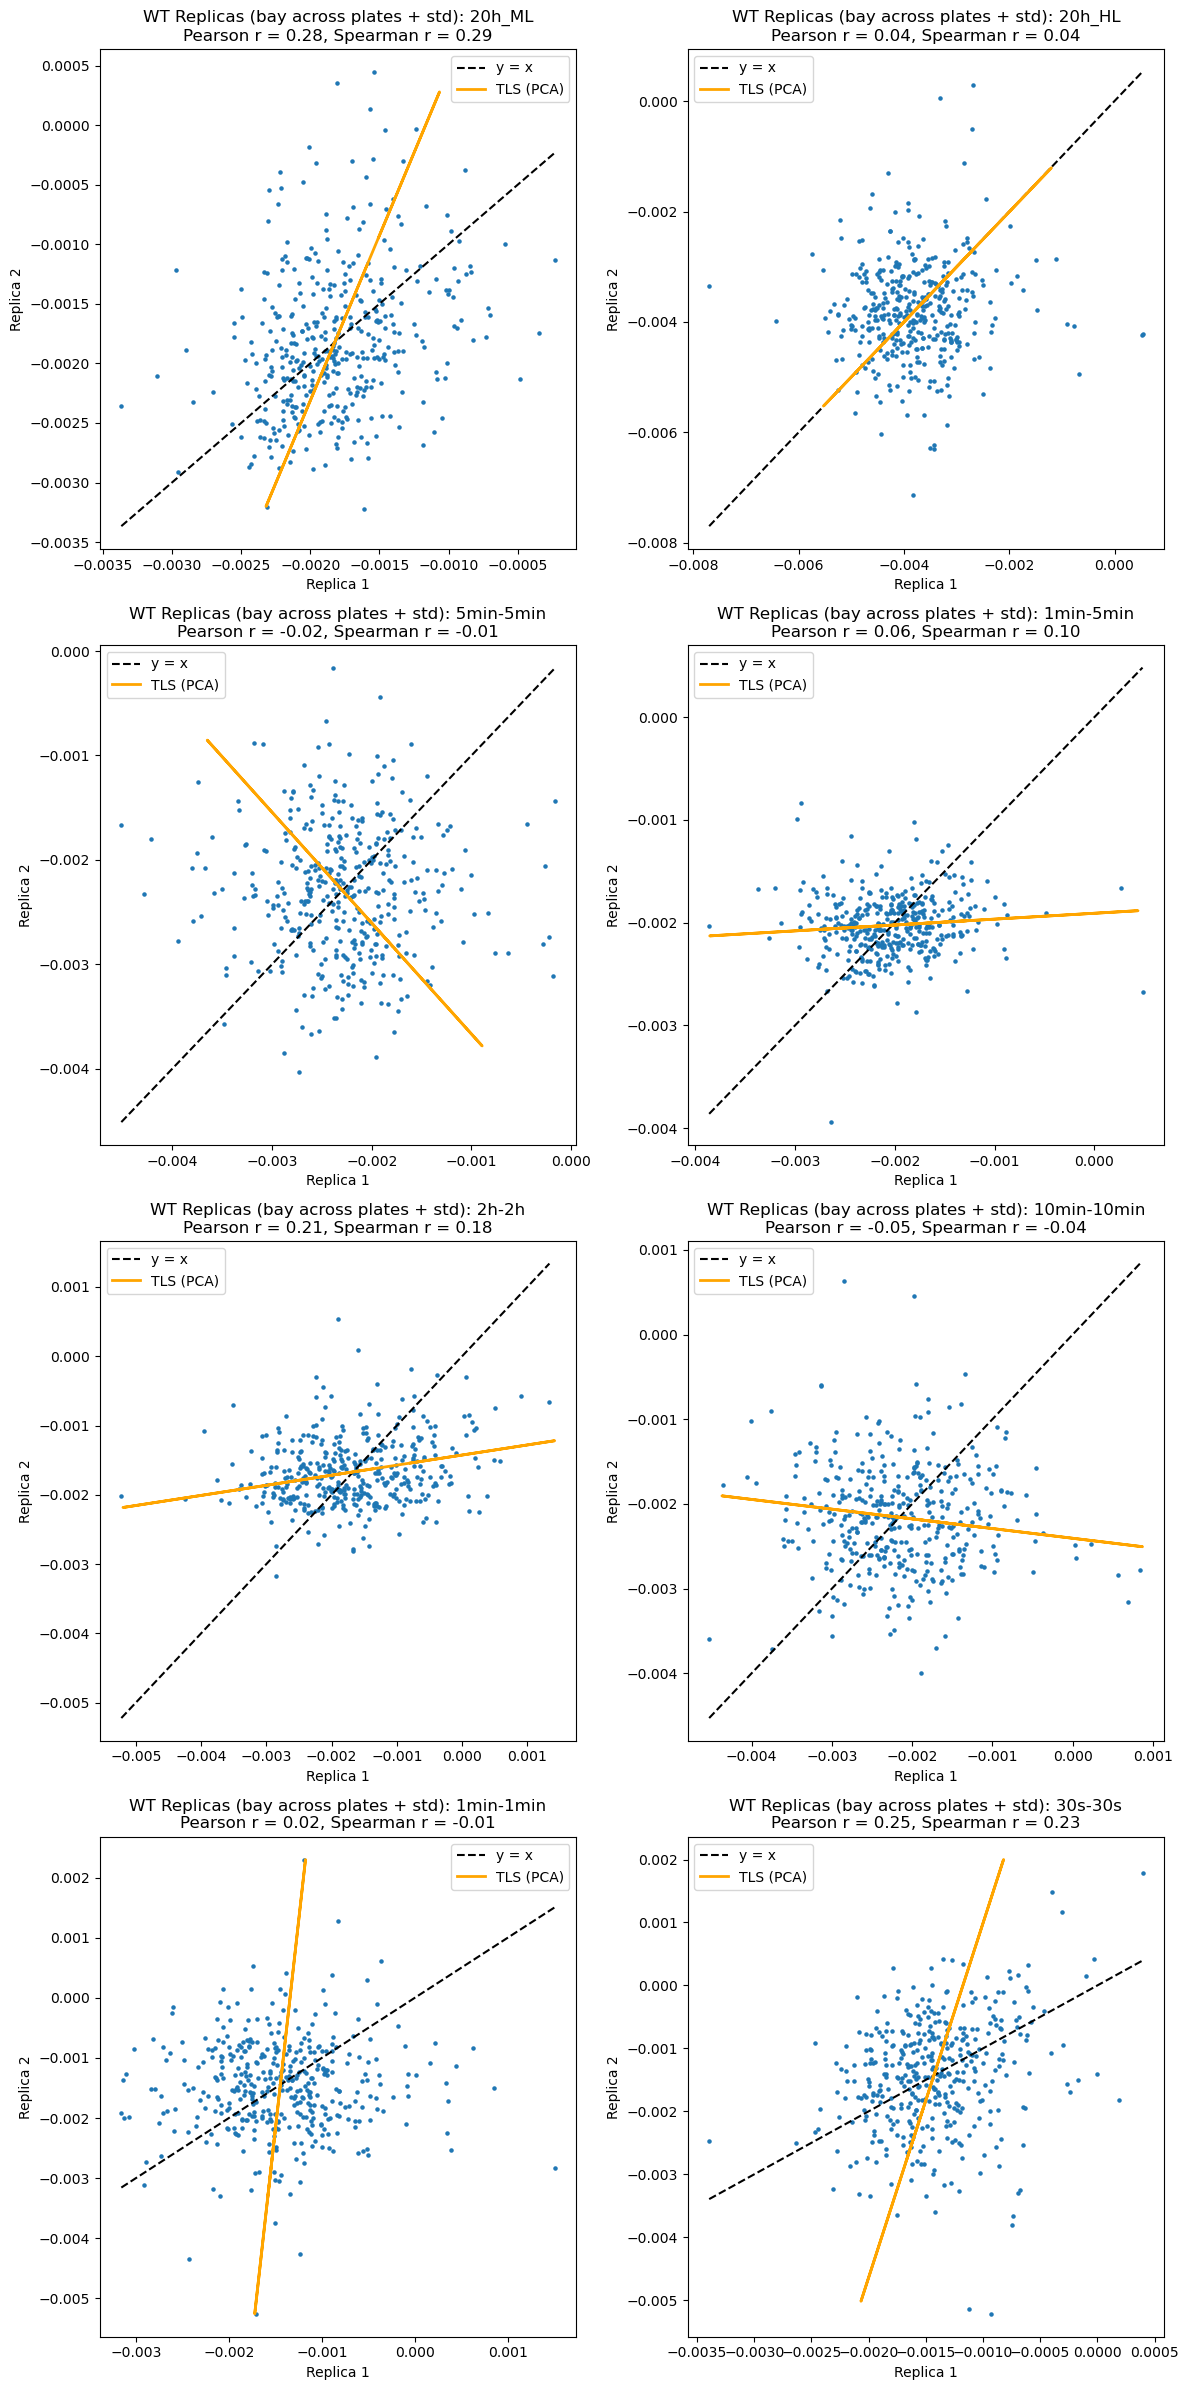

In [63]:
plot_pairwise_wildtype_tls(wt_df3, title_prefix='WT Replicas (bay across plates + std): ')

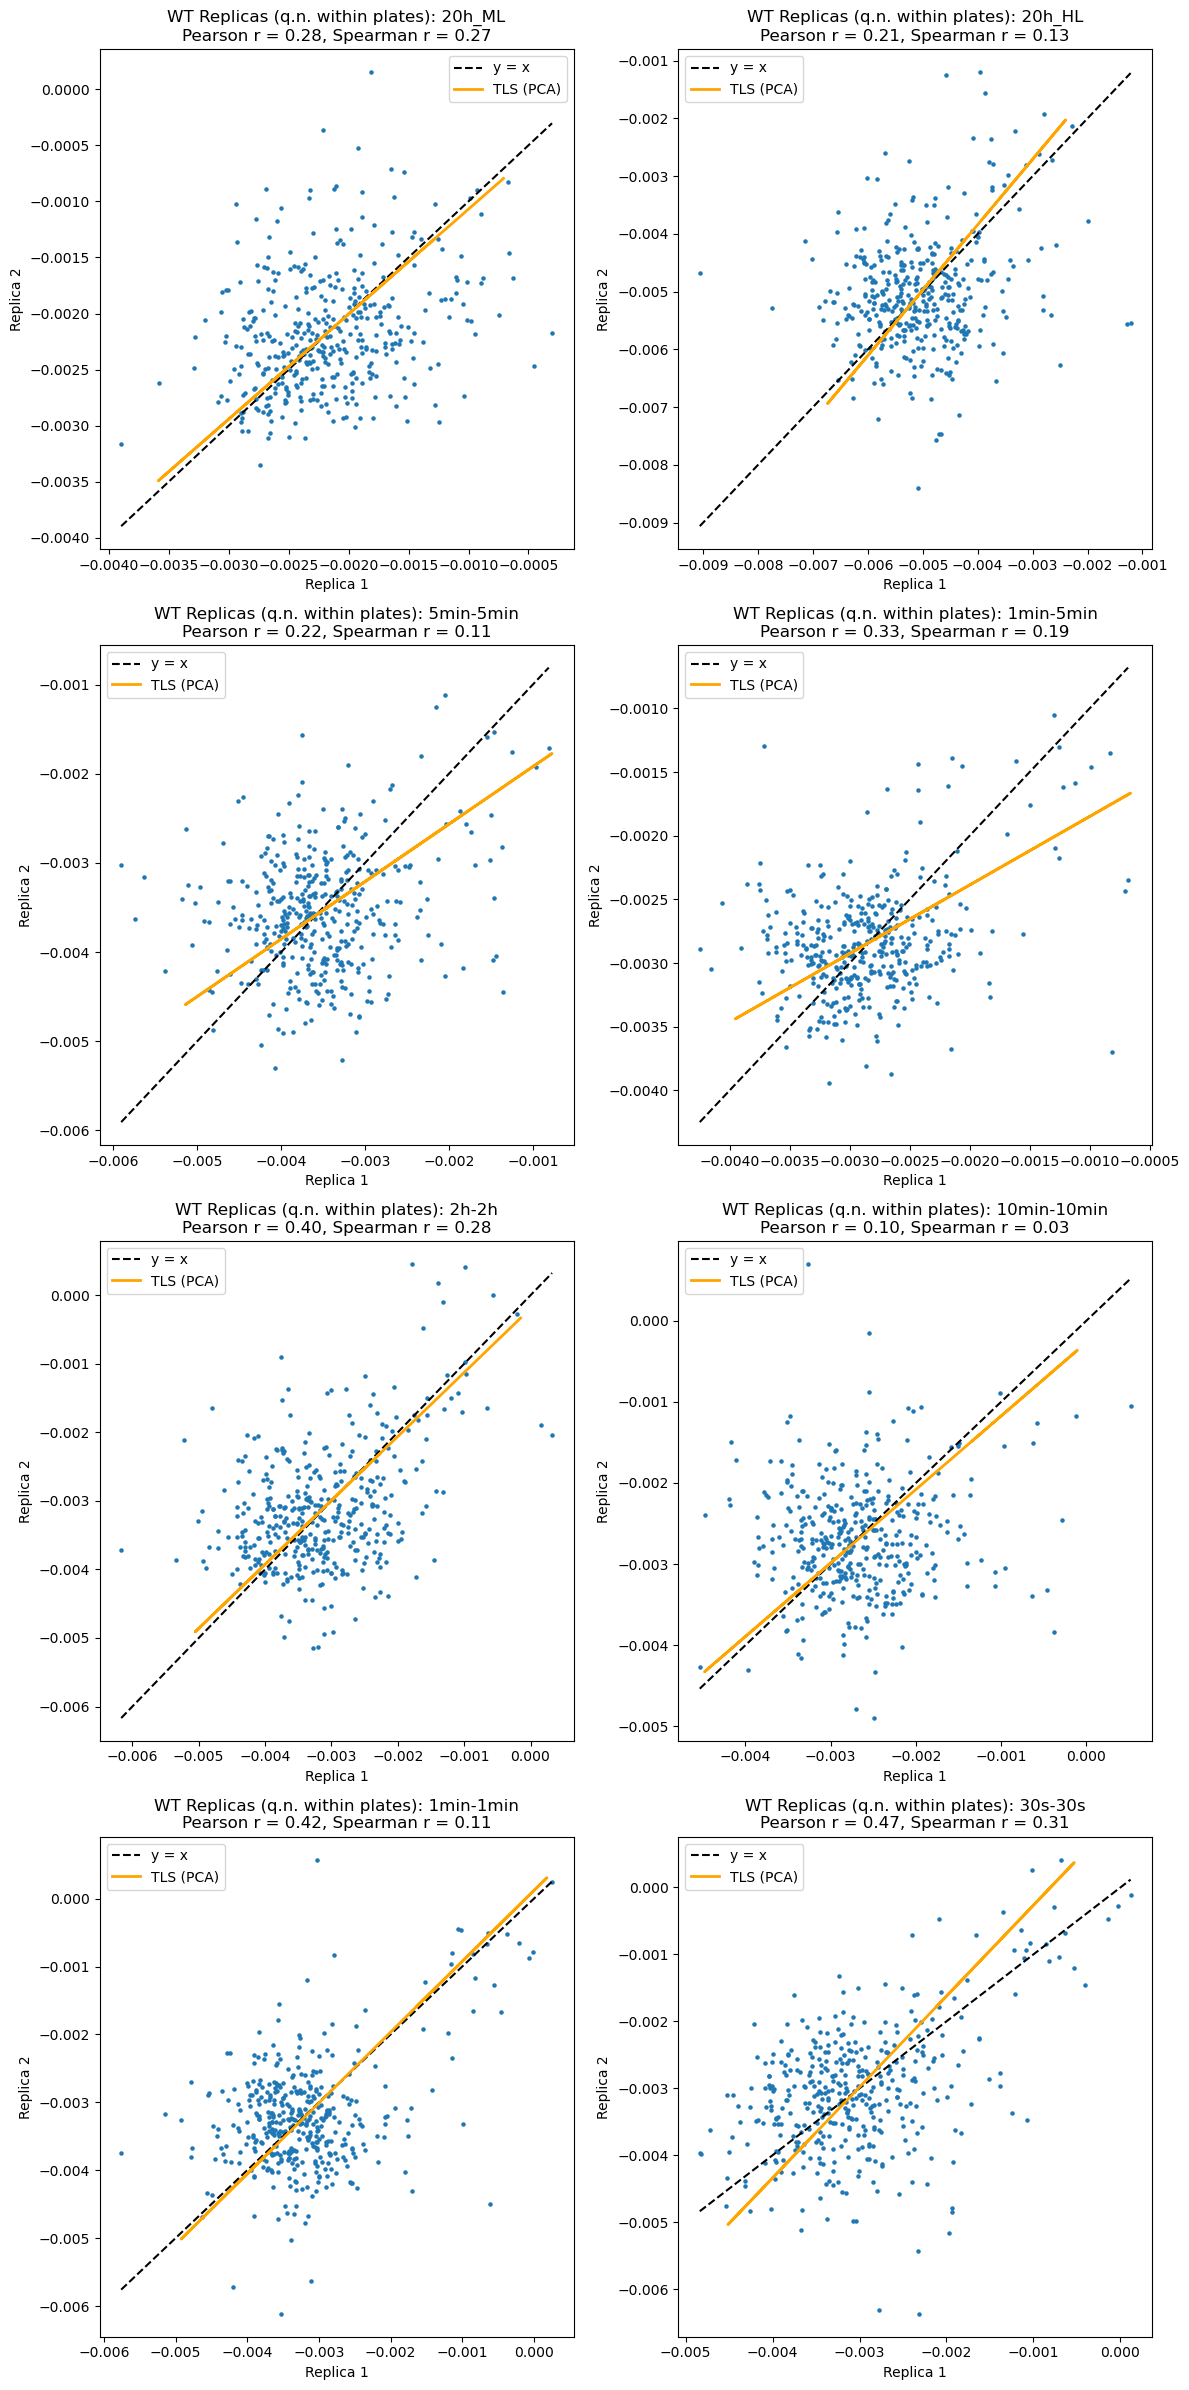

In [50]:
plot_pairwise_wildtype_tls(wt_df4, title_prefix='WT Replicas (q.n. within plates): ')